<a href="https://colab.research.google.com/github/DeokhuiHan/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_4%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 오픈소스 기반 데이터 분석 4강 - 데이터 수집


## 4-1 CSV 파일 읽기

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib 한글 폰트 설정
#plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
#plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# TODO: 본인의 학번 뒤 4자리로 변경
LAST_4_DIGITS = "3765"

# --- 1. API 설정 및 데이터 수집 ---
api_key = "554a6d55756a75723438656b43596f"
# 서울시 에너지 사용량 정보 API의 기본 URL
BASE_URL_START = f"URL = http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/"



# 계절 분류 함수
def get_season(month):
    """월을 입력받아 계절을 반환합니다."""
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'


# 데이터를 저장할 빈 DataFrame 초기화
full_df = pd.DataFrame()
data_found = False

print("--- 데이터 수집 시작 (2015년 ~ 2024년) ---")

# API 호출 및 데이터 추출 (1-5번째 레코드 범위로 호출)
for year in range(2015, 2025):
    for month in range(1, 13):
        # API URL 구성 (레코드 범위 1/5는 유지)
        url = f"{BASE_URL_START}1/5/{year}/{month}/"

        try:
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()

                # FIX: 중첩된 JSON 구조에서 실제 데이터 'row'를 추출
                if 'energyUseDataSummaryInfo' in data and 'row' in data['energyUseDataSummaryInfo']:
                    records = data['energyUseDataSummaryInfo']['row']

                    if records:
                        df_temp = pd.DataFrame(records)
                        df_temp['year'] = year
                        df_temp['month'] = month

                        # DataFrame 결합
                        full_df = pd.concat([full_df, df_temp], ignore_index=True)
                        data_found = True
                    # else: 'row' 리스트가 비어있을 경우 무시

                # API에서 에러 코드(예: INFO-100)를 반환할 경우 무시
                elif 'RESULT' in data and data['RESULT']['CODE'] == 'INFO-100':
                    pass
                else:
                    # 기타 예상치 못한 응답 구조 처리
                    pass

            else:
                print(f"오류: {year}년 {month}월 호출 실패. 상태 코드: {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"네트워크 오류: {year}년 {month}월 API 호출 중 오류 발생: {e}")
        except requests.exceptions.JSONDecodeError:
            print(f"디코딩 오류: {year}년 {month}월 응답을 JSON으로 변환할 수 없습니다.")

print(f"--- 데이터 수집 완료 (총 {len(full_df)}개 레코드) ---")

if not data_found:
    print("오류: 데이터를 수집하지 못했습니다. 스크립트를 종료합니다.")
else:
    # --- 2. 데이터 전처리 및 준비 ---

    # FIX: API 응답에서 확인된 실제 컬럼 이름(약어)으로 변경
    # 'CRNT_ELEC_QTY' -> 'EUS', 'CRNT_GAS_QTY' -> 'GUS' 등으로 매핑
    energy_cols = ['EUS', 'GUS', 'WUS', 'HUS']

    # 모든 필수 에너지 컬럼이 DataFrame에 있는지 확인
    if not all(col in full_df.columns for col in energy_cols):
        # 수정: 'energy_df'를 'full_df'로 변경하여 NameError 해결
        print(f"치명적 오류: 필수 에너지 컬럼이 데이터에 포함되어 있지 않습니다: {full_df.columns.tolist()}")
    else:
        # 에너지 사용량 컬럼을 숫자형으로 변환 (변환 불가능한 값은 NaN 처리)
        for col in energy_cols:
            full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

        # NaN 값이 포함된 행 제거 (분석 정확도를 위해)
        full_df.dropna(subset=energy_cols, inplace=True)

        # 'season' 컬럼 추가
        full_df['season'] = full_df['month'].apply(get_season)

        # 정제된 데이터 정보 출력
        print("\n[정제된 데이터 정보]")
        print(full_df.info())
        print("\n[정제된 데이터 미리보기]")
        print(full_df[['year', 'month', 'season'] + energy_cols].head())

        # --- 3-1. 연도별 에너지 사용 총 사용량 변화 시각화 ---

        # FIX: 약어 컬럼 이름('EUS', 'GUS', ...)을 사용하여 총 에너지 계산
        full_df['TOTAL_ENERGY_QTY'] = full_df['EUS'] + full_df['GUS'] + full_df['WUS'] + full_df['HUS']

        # 연도별 총 사용량 집계
        yearly_total = full_df.groupby('year')['TOTAL_ENERGY_QTY'].sum().reset_index()

        # 선 그래프 시각화
        plt.figure(figsize=(10, 6))

        if not yearly_total.empty:
            sns.lineplot(x='year', y='TOTAL_ENERGY_QTY', data=yearly_total, marker='o', color='#3b82f6')

            # 그래프 제목 및 레이블 설정
            title = f"연도별 에너지 사용 총 사용량 변화 - {LAST_4_DIGITS}"
            plt.title(title, fontsize=16)
            plt.xlabel("연도", fontsize=12)
            plt.ylabel("총 에너지 사용량 (합산)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)

            # x축 틱을 연도별로 표시
            plt.xticks(yearly_total['year'].unique())
            plt.tight_layout()

            # 그래프 저장
            file_name_3_1 = f"yearly_total_energy_trend_{LAST_4_DIGITS}.png"
            plt.savefig(file_name_3_1)
            plt.show()
            print(f"\n그래프 저장 완료: {file_name_3_1}")
        else:
            print("\n시각화할 데이터가 부족합니다. 연도별 집계 결과가 비어있습니다.")

        # --- 3-2. 계절별 가스 사용량 평균 시각화 ---

        # 1. 평균 계산
        seasonal_gas_avg = full_df.groupby('season')['GUS'].mean().reset_index()

        # 2. 원하는 계절 순서 정의
        season_order = ['봄', '여름', '가을', '겨울']

        # 3. 인덱스를 'season'으로 설정하고, season_order로 재설정(reindex)합니다.
        #    누락된 계절(봄, 여름)의 'GUS' 평균값을 0으로 채웁니다.
        seasonal_gas_avg = seasonal_gas_avg.set_index('season').reindex(season_order).fillna(0).reset_index()
        seasonal_gas_avg['season'] = pd.Categorical(seasonal_gas_avg['season'], categories=season_order, ordered=True)
        seasonal_gas_avg = seasonal_gas_avg.sort_values('season')

        # 막대 그래프 시각화
        plt.figure(figsize=(10, 6))

        if not seasonal_gas_avg.empty:
            ax = sns.barplot(x='season', y='GUS', data=seasonal_gas_avg, palette='viridis')

            # 막대 위에 값 표시 (데이터 레이블)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 9),
                            textcoords='offset points')

            # 그래프 제목 및 레이블 설정
            title_3_2 = f"계절별 가스 사용량 평균 - {LAST_4_DIGITS}"
            plt.title(title_3_2, fontsize=16)
            plt.xlabel("계절", fontsize=12)
            plt.ylabel("가스 사용량 평균 (GUS)", fontsize=12)
            plt.tight_layout()

            # 그래프 저장
            file_name_3_2 = f"seasonal_gas_avg_{LAST_4_DIGITS}.png"
            plt.savefig(file_name_3_2)
            plt.show()
            print(f"\n그래프 저장 완료: {file_name_3_2}")
        else:
            print("\n시각화할 데이터가 부족합니다. 계절별 집계 결과가 비어있습니다.")

--- 데이터 수집 시작 (2015년 ~ 2024년) ---
네트워크 오류: 2015년 1월 API 호출 중 오류 발생: No connection adapters were found for 'URL = http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/2015/1/'
네트워크 오류: 2015년 2월 API 호출 중 오류 발생: No connection adapters were found for 'URL = http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/2015/2/'
네트워크 오류: 2015년 3월 API 호출 중 오류 발생: No connection adapters were found for 'URL = http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/2015/3/'
네트워크 오류: 2015년 4월 API 호출 중 오류 발생: No connection adapters were found for 'URL = http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/2015/4/'
네트워크 오류: 2015년 5월 API 호출 중 오류 발생: No connection adapters were found for 'URL = http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/2015/5/'
네트워크 오류: 2015년 6월 API 호출 중 오류 발생: No conn

--- 데이터 수집 시작 (2015년 ~ 2024년) ---


/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


--- 데이터 수집 완료 (총 150개 레코드) ---

[정제된 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      150 non-null    object 
 1   MON       150 non-null    object 
 2   MM_TYPE   150 non-null    object 
 3   CNT       150 non-null    object 
 4   EUS       150 non-null    int64  
 5   EUS1      150 non-null    object 
 6   EUS2      150 non-null    object 
 7   ECO2_1    150 non-null    object 
 8   ECO2_2    150 non-null    object 
 9   GUS       150 non-null    int64  
 10  GUS1      150 non-null    object 
 11  GUS2      150 non-null    object 
 12  GCO2_1    150 non-null    object 
 13  GCO2_2    150 non-null    object 
 14  WUS       150 non-null    float64
 15  WUS1      150 non-null    object 
 16  WUS2      150 non-null    object 
 17  WCO2_1    150 non-null    object 
 18  WCO2_2    150 non-null    object 
 19  HUS       150 non-null    

/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3898508927.py:136: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_l

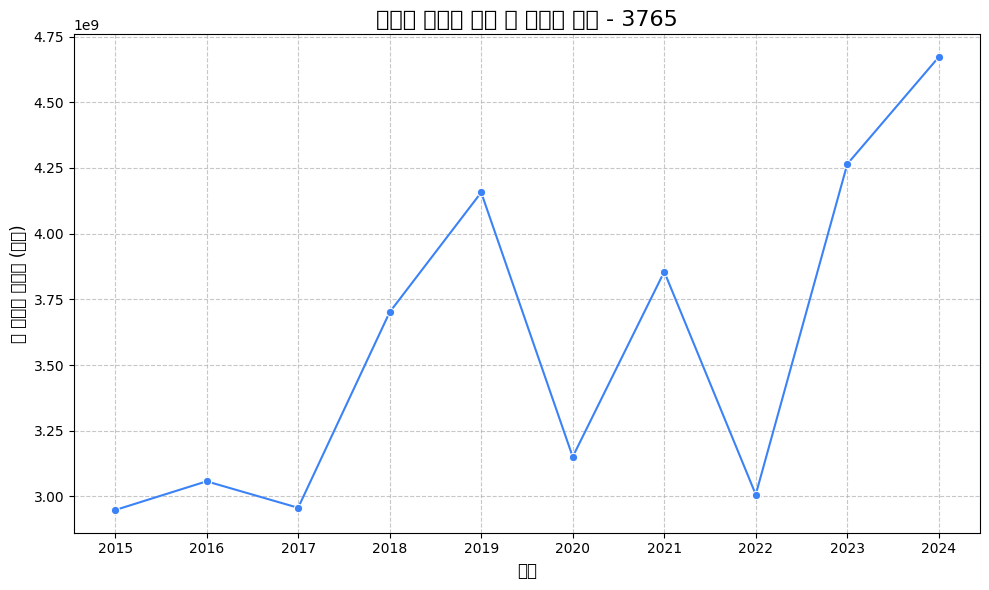


그래프 저장 완료: yearly_total_energy_trend_3765.png


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# Matplotlib 한글 폰트 설정


# TODO: 본인의 학번 뒤 4자리로 변경
LAST_4_DIGITS = "3765"

# --- 1. API 설정 및 데이터 수집 ---
api_key = "554a6d55756a75723438656b43596f"
# 서울시 에너지 사용량 정보 API의 기본 URL
BASE_URL_START = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/"

# 계절 분류 함수
def get_season(month):
    """월을 입력받아 계절을 반환합니다."""
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'

# 데이터를 저장할 빈 DataFrame 초기화
full_df = pd.DataFrame()
data_found = False

print("--- 데이터 수집 시작 (2015년 ~ 2024년) ---")

# API 호출 및 데이터 추출 (1-5번째 레코드 범위로 호출)
for year in range(2015, 2025):
    for month in range(1, 13):
        # API URL 구성 (레코드 범위 1/5는 유지)
        url = f"{BASE_URL_START}1/5/{year}/{month}/"

        try:
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()

                # FIX: 중첩된 JSON 구조에서 실제 데이터 'row'를 추출
                if 'energyUseDataSummaryInfo' in data and 'row' in data['energyUseDataSummaryInfo']:
                    records = data['energyUseDataSummaryInfo']['row']

                    if records:
                        df_temp = pd.DataFrame(records)
                        df_temp['year'] = year
                        df_temp['month'] = month

                        # DataFrame 결합
                        full_df = pd.concat([full_df, df_temp], ignore_index=True)
                        data_found = True
                    # else: 'row' 리스트가 비어있을 경우 무시

                # API에서 에러 코드(예: INFO-100)를 반환할 경우 무시
                elif 'RESULT' in data and data['RESULT']['CODE'] == 'INFO-100':
                     pass
                else:
                    # 기타 예상치 못한 응답 구조 처리
                    pass

            else:
                print(f"오류: {year}년 {month}월 호출 실패. 상태 코드: {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"네트워크 오류: {year}년 {month}월 API 호출 중 오류 발생: {e}")
        except requests.exceptions.JSONDecodeError:
            print(f"디코딩 오류: {year}년 {month}월 응답을 JSON으로 변환할 수 없습니다.")


print(f"--- 데이터 수집 완료 (총 {len(full_df)}개 레코드) ---")

if not data_found:
    print("오류: 데이터를 수집하지 못했습니다. 스크립트를 종료합니다.")
else:
    # --- 2. 데이터 전처리 및 준비 ---

    # FIX: API 응답에서 확인된 실제 컬럼 이름(약어)으로 변경
    # 'CRNT_ELEC_QTY' -> 'EUS', 'CRNT_GAS_QTY' -> 'GUS' 등으로 매핑
    energy_cols = ['EUS', 'GUS', 'WUS', 'HUS']

    # 모든 필수 에너지 컬럼이 DataFrame에 있는지 확인
    if not all(col in full_df.columns for col in energy_cols):
        # 수정: 'energy_df'를 'full_df'로 변경하여 NameError 해결
        print(f"치명적 오류: 필수 에너지 컬럼이 데이터에 포함되어 있지 않습니다: {full_df.columns.tolist()}")
    else:
        # 에너지 사용량 컬럼을 숫자형으로 변환 (변환 불가능한 값은 NaN 처리)
        for col in energy_cols:
            full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

        # NaN 값이 포함된 행 제거 (분석 정확도를 위해)
        full_df.dropna(subset=energy_cols, inplace=True)

        # 'season' 컬럼 추가
        full_df['season'] = full_df['month'].apply(get_season)

        # 정제된 데이터 정보 출력
        print("\n[정제된 데이터 정보]")
        print(full_df.info())
        print("\n[정제된 데이터 미리보기]")
        print(full_df[['year', 'month', 'season'] + energy_cols].head())

        # --- 3-1. 연도별 에너지 사용 총 사용량 변화 시각화 ---

        # FIX: 약어 컬럼 이름('EUS', 'GUS', ...)을 사용하여 총 에너지 계산
        full_df['TOTAL_ENERGY_QTY'] = full_df['EUS'] + full_df['GUS'] + full_df['WUS'] + full_df['HUS']

        # 연도별 총 사용량 집계
        yearly_total = full_df.groupby('year')['TOTAL_ENERGY_QTY'].sum().reset_index()

        # 선 그래프 시각화
        plt.figure(figsize=(10, 6))

        if not yearly_total.empty:
            sns.lineplot(x='year', y='TOTAL_ENERGY_QTY', data=yearly_total, marker='o', color='#3b82f6')

            # 그래프 제목 및 레이블 설정
            title = f"연도별 에너지 사용 총 사용량 변화 - {LAST_4_DIGITS}"
            plt.title(title, fontsize=16)
            plt.xlabel("연도", fontsize=12)
            plt.ylabel("총 에너지 사용량 (합산)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)

            # x축 틱을 연도별로 표시
            plt.xticks(yearly_total['year'].unique())
            plt.tight_layout()

            # 그래프 저장
            file_name_3_1 = f"yearly_total_energy_trend_{LAST_4_DIGITS}.png"
            plt.savefig(file_name_3_1)
            plt.show()
            print(f"\n그래프 저장 완료: {file_name_3_1}")
        else:
            print("\n시각화할 데이터가 부족합니다. 연도별 집계 결과가 비어있습니다.")


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and direc

In [ ]:
import requests
import pandas as pd

api_key = "554a6d55756a75723438656b43596f"
base_url = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/1/5/"

params = {
    'serviceKey': api_key,
    'returnType': 'json',
    'numOfRows': '100',
    'pageNo': '1',
    'sidoName': '서울',
    'ver': '1.0'
}

data_list = []

for year in range(2015, 2025):
    for month in range(1, 13):
        url = f"{base_url}/{year}/{month}"
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            data_list.append(data)
        else:
            print("Error")

print("호출성공 & 데이터 수집 완료!")

df = pd.DataFrame(data_list)
print(df.info())
print(df.head())

full_df = pd.DataFrame()

def get_season(month):
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'

for year in range(2015, 2025):
    for month in range(1, 13):
        url = f"{base_url}/{year}/{month}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame(data)
            df['year'] = year
            df['month'] = month
            full_df = pd.concat([full_df, df], ignore_index=True)

full_df['season'] = full_df['month'].apply(get_season)
print(full_df[['year', 'month', 'season']].head())
full_df

import matplotlib.pyplot as plt
import seaborn as sns


!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# Matplotlib의 기본 폰트 설정이 없는 환경이라면, 위의 설정을 실행해야 합니다.

# 학번 뒤 4자리 (TODO: 본인의 학번으로 변경)
LAST_4_DIGITS = "3765"


### 3-1. 연도별 에너지 사용 총 사용량 변화


# 에너지 사용 총량 컬럼 생성
df['TOTAL_ENERGY_QTY'] = df['CRNT_ELEC_QTY'] + df['CRNT_GAS_QTY'] + df['CRNT_WTR_QTY'] + df['CRNT_HEAT_QTY']

# 연도별 총 사용량 집계
yearly_total = df.groupby('year')['TOTAL_ENERGY_QTY'].sum().reset_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='TOTAL_ENERGY_QTY', data=yearly_total, marker='o')

# 그래프 제목 및 레이블 설정
title = f"연도별 에너지 사용 총 사용량 변화 - {LAST_4_DIGITS}"
plt.title(title, fontsize=16)
plt.xlabel("연도", fontsize=12)
plt.ylabel("총 에너지 사용량 (합산)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(yearly_total['year']) # x축 틱을 연도별로 표시
plt.tight_layout()

# 그래프 저장 (파일 이름도 학번에 맞춰 변경)
file_name_3_1 = f"yearly_total_energy_trend_{3765}.png"
plt.savefig(file_name_3_1)
plt.show()

호출성공 & 데이터 수집 완료!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   energyUseDataSummaryInfo  120 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB
None
                            energyUseDataSummaryInfo
0  {'list_total_count': 1241, 'RESULT': {'CODE': ...
1  {'list_total_count': 1241, 'RESULT': {'CODE': ...
2  {'list_total_count': 1241, 'RESULT': {'CODE': ...
3  {'list_total_count': 1241, 'RESULT': {'CODE': ...
4  {'list_total_count': 1241, 'RESULT': {'CODE': ...
   year  month season
0  2015      1     겨울
1  2015      1     겨울
2  2015      1     겨울
3  2015      2     겨울
4  2015      2     겨울
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr

KeyError: 'CRNT_ELEC_QTY'

In [ ]:
from matplotlib import font_manager
font_manager.findSystemFonts()

['/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/Li

--- 데이터 수집 시작 (2015년 ~ 2024년) ---


/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2947381822.py:135: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layo

--- 데이터 수집 완료 (총 150개 레코드) ---

[정제된 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      150 non-null    object 
 1   MON       150 non-null    object 
 2   MM_TYPE   150 non-null    object 
 3   CNT       150 non-null    object 
 4   EUS       150 non-null    int64  
 5   EUS1      150 non-null    object 
 6   EUS2      150 non-null    object 
 7   ECO2_1    150 non-null    object 
 8   ECO2_2    150 non-null    object 
 9   GUS       150 non-null    int64  
 10  GUS1      150 non-null    object 
 11  GUS2      150 non-null    object 
 12  GCO2_1    150 non-null    object 
 13  GCO2_2    150 non-null    object 
 14  WUS       150 non-null    float64
 15  WUS1      150 non-null    object 
 16  WUS2      150 non-null    object 
 17  WCO2_1    150 non-null    object 
 18  WCO2_2    150 non-null    object 
 19  HUS       150 non-null    

/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.savefig(file_name_3_1)
/tmp/ipython-input-2947381822.py:139: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) mi

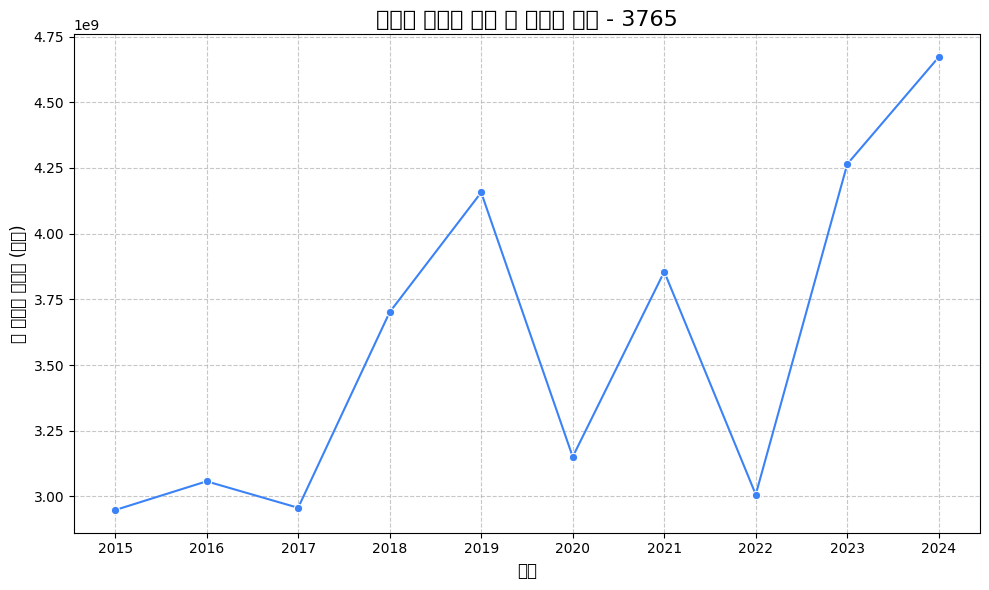


그래프 저장 완료: yearly_total_energy_trend_3765.png


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib 한글 폰트 설정
#plt.rcParams['font.family'] = 'HYPost' # Windows 사용자
#plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline
# TODO: 본인의 학번 뒤 4자리로 변경
LAST_4_DIGITS = "3765"

# --- 1. API 설정 및 데이터 수집 ---
api_key = "554a6d55756a75723438656b43596f"
# 서울시 에너지 사용량 정보 API의 기본 URL
BASE_URL_START = f"http://openapi.seoul.go.kr:8088/{api_key}/json/energyUseDataSummaryInfo/"

# 계절 분류 함수
def get_season(month):
    """월을 입력받아 계절을 반환합니다."""
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'

# 데이터를 저장할 빈 DataFrame 초기화
full_df = pd.DataFrame()
data_found = False

print("--- 데이터 수집 시작 (2015년 ~ 2024년) ---")

# API 호출 및 데이터 추출 (1-5번째 레코드 범위로 호출)
for year in range(2015, 2025):
    for month in range(1, 13):
        # API URL 구성 (레코드 범위 1/5는 유지)
        url = f"{BASE_URL_START}1/5/{year}/{month}/"

        try:
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()

                # FIX: 중첩된 JSON 구조에서 실제 데이터 'row'를 추출
                if 'energyUseDataSummaryInfo' in data and 'row' in data['energyUseDataSummaryInfo']:
                    records = data['energyUseDataSummaryInfo']['row']

                    if records:
                        df_temp = pd.DataFrame(records)
                        df_temp['year'] = year
                        df_temp['month'] = month

                        # DataFrame 결합
                        full_df = pd.concat([full_df, df_temp], ignore_index=True)
                        data_found = True
                    # else: 'row' 리스트가 비어있을 경우 무시

                # API에서 에러 코드(예: INFO-100)를 반환할 경우 무시
                elif 'RESULT' in data and data['RESULT']['CODE'] == 'INFO-100':
                     pass
                else:
                    # 기타 예상치 못한 응답 구조 처리
                    pass

            else:
                print(f"오류: {year}년 {month}월 호출 실패. 상태 코드: {response.status_code}")

        except requests.exceptions.RequestException as e:
            print(f"네트워크 오류: {year}년 {month}월 API 호출 중 오류 발생: {e}")
        except requests.exceptions.JSONDecodeError:
            print(f"디코딩 오류: {year}년 {month}월 응답을 JSON으로 변환할 수 없습니다.")


print(f"--- 데이터 수집 완료 (총 {len(full_df)}개 레코드) ---")

if not data_found:
    print("오류: 데이터를 수집하지 못했습니다. 스크립트를 종료합니다.")
else:
    # --- 2. 데이터 전처리 및 준비 ---

    # FIX: API 응답에서 확인된 실제 컬럼 이름(약어)으로 변경
    # 'CRNT_ELEC_QTY' -> 'EUS', 'CRNT_GAS_QTY' -> 'GUS' 등으로 매핑
    energy_cols = ['EUS', 'GUS', 'WUS', 'HUS']

    # 모든 필수 에너지 컬럼이 DataFrame에 있는지 확인
    if not all(col in full_df.columns for col in energy_cols):
        # 수정: 'energy_df'를 'full_df'로 변경하여 NameError 해결
        print(f"치명적 오류: 필수 에너지 컬럼이 데이터에 포함되어 있지 않습니다: {full_df.columns.tolist()}")
    else:
        # 에너지 사용량 컬럼을 숫자형으로 변환 (변환 불가능한 값은 NaN 처리)
        for col in energy_cols:
            full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

        # NaN 값이 포함된 행 제거 (분석 정확도를 위해)
        full_df.dropna(subset=energy_cols, inplace=True)

        # 'season' 컬럼 추가
        full_df['season'] = full_df['month'].apply(get_season)

        # 정제된 데이터 정보 출력
        print("\n[정제된 데이터 정보]")
        print(full_df.info())
        print("\n[정제된 데이터 미리보기]")
        print(full_df[['year', 'month', 'season'] + energy_cols].head())

        # --- 3-1. 연도별 에너지 사용 총 사용량 변화 시각화 ---

        # FIX: 약어 컬럼 이름('EUS', 'GUS', ...)을 사용하여 총 에너지 계산
        full_df['TOTAL_ENERGY_QTY'] = full_df['EUS'] + full_df['GUS'] + full_df['WUS'] + full_df['HUS']

        # 연도별 총 사용량 집계
        yearly_total = full_df.groupby('year')['TOTAL_ENERGY_QTY'].sum().reset_index()

        # 선 그래프 시각화
        plt.figure(figsize=(10, 6))

        if not yearly_total.empty:
            sns.lineplot(x='year', y='TOTAL_ENERGY_QTY', data=yearly_total, marker='o', color='#3b82f6')

            # 그래프 제목 및 레이블 설정
            title = f"연도별 에너지 사용 총 사용량 변화 - {LAST_4_DIGITS}"
            plt.title(title, fontsize=16)
            plt.xlabel("연도", fontsize=12)
            plt.ylabel("총 에너지 사용량 (합산)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)

            # x축 틱을 연도별로 표시
            plt.xticks(yearly_total['year'].unique())
            plt.tight_layout()

            # 그래프 저장
            file_name_3_1 = f"yearly_total_energy_trend_{LAST_4_DIGITS}.png"
            plt.savefig(file_name_3_1)
            plt.show()
            print(f"\n그래프 저장 완료: {file_name_3_1}")
        else:
            print("\n시각화할 데이터가 부족합니다. 연도별 집계 결과가 비어있습니다.")

In [ ]:
import pandas as pd

## data.csv 파일 읽기
df = pd.read_csv('data.csv', encoding='utf-8', sep=',', header=0,
                 index_col=None, skiprows=None, nrows=None)
print(df)

           날짜    체중  골격근량  체지방량
0  2025.02.06  64.7  30.0  11.1
1  2025.02.04  64.0  29.3  11.6


## 4-2 JSON 파일 읽기



In [ ]:
import json
import pandas as pd

## data.json 파일 출력
with open('data.json', mode='r',encoding='utf-8') as f:
    data = json.load(f)
    print(data)
## data.json 파일 DataFrame 읽기
df= pd.read_json('data.json', orient='records', encoding='utf-8', )
print(df)

{'매출데이터': [{'월': '2025-01', '매출액': 1000000, '비용': 700000, '이익': 300000}, {'월': '2025-02', '매출액': 1200000, '비용': 800000, '이익': 400000}, {'월': '2025-03', '매출액': 1500000, '비용': 900000, '이익': 600000}]}
                                               매출데이터
0  {'월': '2025-01', '매출액': 1000000, '비용': 700000,...
1  {'월': '2025-02', '매출액': 1200000, '비용': 800000,...
2  {'월': '2025-03', '매출액': 1500000, '비용': 900000,...


## 4-3 텍스트 파일 읽기 및 데이터 추출

In [ ]:
import re

## 파일(callcenter20250301.log) 오픈 및 읽기
with open('callcenter20250301.log', 'r', encoding='utf-8') as f:
    content = f.read()
## 주민등록번호 패턴 생성
masked_content = pattern = re.compile(r'(\d{6})-(\d{7})')

## 주민등록번호 마스킹
masked_content = pattern.sub(r'\1-*******', content)

## 마스킹된 파일(callcenter20250301_masked.log) 오픈 및 쓰기
with open('callcenter20250301_masked.log', mode='w') as f:
    f.write(masked_content)

print("주민등록번호 마스킹 완료. 'callcenter20250301_masked.log.txt' 파일로 저장되었습니다.")

주민등록번호 마스킹 완료. 'callcenter20250301_masked.log.txt' 파일로 저장되었습니다.


## 4-4 Open-Meteo의 무료 날씨 API를 통한 특정 지역 온도 조회

In [ ]:
import requests
import json
url = "http://api.open-meteo.com/v1/forecast?=&=&current=temperature_2m"
params = {
    "latitude": "37.58638333",
    "longitude": "127.0203333",
    "current": "temperature_2m"
}


try:
    ## URL 및 파라미터 전송
    response = requests.get(url, params=params)
    response.raise_for_status()

    ## JSON 데이터 읽기
    data = response.json()

    print("API 응답:", data)
    print("서울시 종로구의 현재 온도는 : {0}{1}입니다")

except requests.exceptions.RequestException as e:
    print(f"API호출실패: {e}")
except json.JSONDecodeError as e:
    print(f"JSON 파싱 실패: {e}")

API 응답: {'latitude': 37.6, 'longitude': 127.0, 'generationtime_ms': 0.056624412536621094, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 29.0, 'current_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature_2m': '°C'}, 'current': {'time': '2025-10-21T05:00', 'interval': 900, 'temperature_2m': 14.4}}
서울시 종로구의 현재 온도는 : {0}{1}입니다


In [ ]:
import requests
import json

url = "https://api.open-meteo.com/v1/forecast?=&=&current=temperature_2m"
params = {
    "latitude": "36.5040736",
    "longitude": "127.2494855",
    "current": "temperature_2m"
}

try:
    ## URL 및 파라미터 전송
    response = requests.get(url, params=params)
    response.raise_for_status()

    ## JSON 데이터 읽기
    data = response.json()

    print("API 응답:", data)
    print("세종시의 현재 온도는 : {0}{1} 입니다.".format(data['current']['temperature_2m'], data['current_units']['temperature_2m']))

except requests.exceptions.RequestException as e:
    print(f"API 호출 실패: {e}")
except json.JSONDecodeError as e:
    print(f"JSON 파싱 실패: {e}")

API 응답: {'latitude': 36.5, 'longitude': 127.25, 'generationtime_ms': 0.03230571746826172, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 32.0, 'current_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature_2m': '°C'}, 'current': {'time': '2025-10-10T02:15', 'interval': 900, 'temperature_2m': 19.7}}
세종시의 현재 온도는 : 19.7°C 입니다.


## 4-5 Selenium과 lxml을 이용한 웹 스크래핑

In [ ]:
!curl -o google-chrome-stable_current_amd64.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!apt install ./google-chrome-stable_current_amd64.deb -y
!pip install selenium webdriver_manager

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  75.7M      0  0:00:01  0:00:01 --:--:-- 75.7M
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'google-chrome-stable' instead of './google-chrome-stable_current_amd64.deb'
The following additional packages will be installed:
  libvulkan1 mesa-vulkan-drivers
The following NEW packages will be installed:
  google-chrome-stable libvulkan1 mesa-vulkan-drivers
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.9 MB/131 MB of archives.
After this operation, 448 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 mesa-vulkan-drivers amd64 23.2.1-1ubuntu3.1~22.04.3 [10.7

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from lxml import html
import time

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')               # 브라우저 창 없이 실행
chrome_options.add_argument('--no-sandbox')             # 보안모드 비활성화 (Colab 필수)
chrome_options.add_argument('--disable-dev-shm-usage')  # 메모리 부족 방지 (Colab 필수)
chrome_options.add_argument('--window-size=1920x1080')  # 창 크기 설정(가상)
chrome_options.add_argument('--disable-gpu')            # GPU 가속 비활성화 (일부 환경 안정성)
chrome_options.binary_location = "/usr/bin/google-chrome-stable"  # Colab용 크롬 경로 지정

## 드라이버 실행
driver = webdriver.Chrome(options=chrome_options)

## 사이트 접속
## url = 'https://professor.knou.ac.kr/jaehwachung/index.do'
url = 'https://github.com/jaehwachung/Data-Analysis-with-Open-Source'
driver.get(url)

## 사이트 접속 대기
time.sleep(2)

## 페이지 제목 출력
page_source = driver.page_source
tree = html.fromstring(page_source)

title_text= tree.xpath('//title/text()')
print(title_text)
## 드라이버 종료
driver.quit()

['GitHub - jaehwachung/Data-Analysis-with-Open-Source: Data Analysis with Open Source']



# 실습 시나리오

## 공공데이터 포털 가입 및 데이터 신청

- [https://www.data.go.kr](https://www.data.go.kr)
- 한국환경공단 에어코리아 대기오염정보 데이터 신청

In [ ]:
import requests

## 데이터 수집 url 및 api key 설정
url = 'http://openapi.seoul.go.kr:8088/554a6d55756a75723438656b43596f/json/energyUseDataSummaryInfo/1/5/{2016}/{1}'
api_key = '554a6d55756a75723438656b43596f'

params = {
    'serviceKey': api_key,
    'returnType': 'json',
    'numOfRows': '100',
    'pageNo': '1',
    'sidoName': '서울',
    'ver': '1.0'
}

## 데이터 수집
response = requests.get(url, params=params)

## 호출 성공/실패 출력
print(response.json())


{'RESULT': {'CODE': 'INFO-200', 'MESSAGE': '해당하는 데이터가 없습니다.'}}
